In [1]:
import numpy as np
import scipy as sp
import tensorflow as tf
import commpy
import pickle

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

import signal_generation as sg
# import waveform_optimiser as wf
import channel_model as ch

from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq
# from scipy.optimize import minimize, NonlinearConstraint
from importlib import reload
from datetime import datetime

2022-11-22 15:20:30.809083: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [24]:
reload(sg)

<module 'signal_generation' from '/home/esf0/PycharmProjects/nn_essential/signal_generation.py'>

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-11-22 15:20:31.860205: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-22 15:20:31.860735: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-22 15:20:31.945468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 15:20:31.945753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Laptop GPU computeCapability: 8.6
coreClock: 1.56GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-11-22 15:20:31.945773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-22 15:20:31.947011: I tensorflow/stream_executor/p

In [12]:
data_dir = 'data/'
job_name = 'test'
n_max_iter = 1

# create parameters
wdm = ch.create_wdm_parameters(n_channels=1, p_ave_dbm=6, n_symbols=2 ** 16, m_order=16, roll_off=0.1, upsampling=16,
                               downsampling_rate=1, symb_freq=34e9, channel_spacing=75e9, n_polarisations=2)

channel = ch.create_channel_parameters(n_spans=25,
                                       z_span=80,
                                       alpha_db=0.2,
                                       gamma=1.2,
                                       noise_figure_db=4.5,
                                       dispersion_parameter=16.8,
                                       dz=1)

# create points which we will use

p_ave_x_dbm = wdm['p_ave_dbm']  # dBm
p_ave_x = (10 ** (p_ave_x_dbm / 10)) / 1000 / 2
modem_x = commpy.QAMModem(wdm['m_order'])
n_bits_x = int(modem_x.num_bits_symbol * wdm['n_symbols'])
bits_x = np.random.randint(0, 2, n_bits_x, int)  # Random bit stream
gray_x = ch.binarytoGray(bits_x, modem_x.num_bits_symbol)  # after gray code

points_x = modem_x.modulate(gray_x) / np.sqrt(modem_x.Es)  # Modulated baud points sQ = mod1.modulate(sB)/np.sqrt(mod1.Es)
points_x = points_x * np.sqrt(p_ave_x)

p_ave_y_dbm = wdm['p_ave_dbm']  # dBm
p_ave_y = (10 ** (p_ave_y_dbm / 10)) / 1000 / 2
modem_y = commpy.QAMModem(wdm['m_order'])
n_bits_y = int(modem_y.num_bits_symbol * wdm['n_symbols'])
bits_y = np.random.randint(0, 2, n_bits_y, int)  # Random bit stream
gray_y = ch.binarytoGray(bits_y, modem_y.num_bits_symbol)  # after gray code

points_y = modem_y.modulate(gray_y) / np.sqrt(modem_y.Es)  # Modulated baud points sQ = mod1.modulate(sB)/np.sqrt(mod1.Es)
points_y = points_y * np.sqrt(p_ave_y)

print('Points was created')

# create RRC filter as first approximation

n_t = wdm['upsampling'] * wdm['n_symbols']
with tf.device('/GPU:0'):
    ft_filter_values = tf.signal.fftshift(tf.signal.fft(ch.rrcosfilter_our(n_t, wdm['roll_off'], 1 / wdm['symb_freq'], wdm['sample_freq'])))
    ft_filter_values = tf.cast(ft_filter_values, tf.complex128)

print('Initial filter was created')

def compose(x_c):
    # x_c -> x_r
    # make a real valued array of size 2n
    n = len(x_c)
    x_r = np.zeros(2 * n)
    x_r[:n] = np.real(x_c)
    x_r[n:] = np.imag(x_c)

    return x_r


def decompose(x_r):
    # x_r -> x_c
    n = len(x_r) // 2
    x_c = np.zeros(n, dtype=np.complex128)
    x_c = x_r[:n] + 1j * x_r[n:]
    return x_c


def upsample_zero_sides(f, new_size):

    n = len(f)
    zeros = np.zeros(int((new_size - n) / 2), dtype=np.complex128)
    return np.concatenate((zeros, f, zeros))


def spectrum_add_zero_sides(spectrum, new_size):

    n = len(spectrum)
    n_add = int((new_size - n) / 2)
    if n % 2 == 0:
        zeros_left = np.zeros(n_add, dtype=np.complex128)
        zeros_right = np.zeros(n_add, dtype=np.complex128)
    else:
        zeros_left = np.zeros(n_add + 1, dtype=np.complex128)
        zeros_right = np.zeros(n_add, dtype=np.complex128)
    return np.concatenate((zeros_left, spectrum, zeros_right))


def get_spec_limited(spectrum, freq, bandwidth):
    ind = np.where(np.logical_and(freq >= -bandwidth / 2, freq <= bandwidth / 2))
    return spectrum[ind]



start_time = datetime.now()
print("Run initial channel")
with tf.device('/GPU:0'):
    result_original = ch.full_line_model_optimise(channel, wdm, points_x, points_y, ft_filter_values, ft_filter_values, return_type='all')
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000
print("Function evaluation took", execution_time, "ms")

ft_filter_size = 2 ** 10 # size of optimized spectrum
bandwidth_frac = 1.2
init_filter_to_optimize = ch.rrcosfilter_our(ft_filter_size, wdm['roll_off'], 1. / wdm['symb_freq'], wdm['sample_freq'])
ft_init_filter = sp.fft.fftshift(sp.fft.fft(init_filter_to_optimize))
freq = fftshift(sp.fft.fftfreq(ft_filter_size, d=1. / wdm['sample_freq']))

# Load results

x_opt = np.load(data_dir + "data_wf_opt6_dbm_25_span_conj_run_1.npy", allow_pickle=True)
# x_opt = np.load(data_dir + "data_wf_opt10_dbm_12_span_conj_run_1.npy", allow_pickle=True)
# x_opt = np.load(data_dir + "data_wf_opt6_dbm_12_span_conj_run_1.npy", allow_pickle=True)
# x_opt = np.load(data_dir + "data_wf_opt6_dbm_12_span_conj_narrow_run_1.npy", allow_pickle=True)
# x_opt = np.load(data_dir + "data_wf_opt6_dbm_12_span_run_1.npy", allow_pickle=True)
cut_spectrum = decompose(x_opt)
# for w-space
spectrum = spectrum_add_zero_sides(cut_spectrum, ft_filter_size)
filter_values = ifft(ifftshift(spectrum))

n_t = wdm['upsampling'] * wdm['n_symbols']
filter_upsampled = upsample_zero_sides(filter_values, n_t)

with tf.device('/GPU:0'):
    filter_upsampled = tf.cast(filter_upsampled, tf.complex128)
    filter_upsampled_conj = tf.cast(np.conjugate(filter_upsampled), tf.complex128)

    ft_filter_values_opt = tf.signal.fftshift(tf.signal.fft(filter_upsampled))
    ft_filter_values_opt_conj = tf.signal.fftshift(tf.signal.fft(filter_upsampled_conj))

start_time = datetime.now()
print("Run optimised channel")
with tf.device('/GPU:0'):
    result_opt = ch.full_line_model_optimise(channel, wdm, points_x, points_y, ft_filter_values_opt, ft_filter_values_opt_conj, return_type='all')
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000
print("Function evaluation took", execution_time, "ms")

Points was created
Initial filter was created
Run initial channel
Average signal power (x / y): 0.0019924 / 0.0019898 (has to be close to 0.0019905)
BER (x / y): (0.07767868041992188, 20363) (0.07915115356445312, 20749)
Q^2-factor (x / y): 1.420860353383552 1.4108043648261956
EVM (x / y): 1.0831186873190806 1.0926265084225073
Function evaluation took 14690.234999999999 ms
Run optimised channel
Average signal power (x / y): 0.0019914 / 0.0019896 (has to be close to 0.0019905)
BER (x / y): (0.0629119873046875, 16492) (0.06349945068359375, 16646)
Q^2-factor (x / y): 1.5307791891998028 1.5260440224863392
EVM (x / y): 0.9921157208878096 0.9995232844589009
Function evaluation took 13793.606 ms


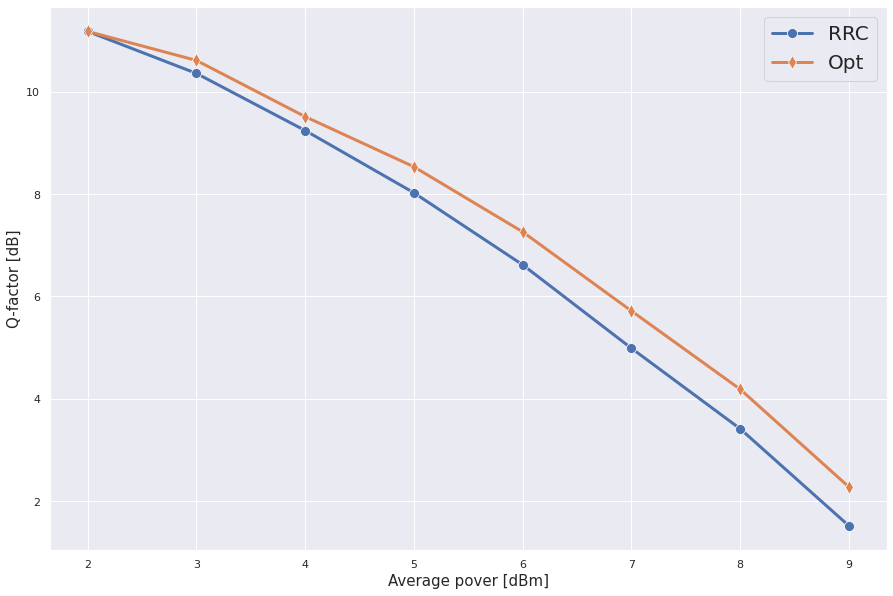

In [25]:
columns = ['n_span', 'p_ave_dbm', 'ber_x', 'ber_x_opt']
result_opt_6dbm = [[12, 6, 0.016048431396484375, 0.01049041748046875],
                   [12, 5, 0.005863189697265625, 0.0037689208984375],
                   [12, 4, 0.00186920166015625, 0.0013885498046875],
                   [12, 3, 0.00048828125, 0.00034332275390625],
                   [12, 2, 0.00014495849609375, 0.00014495849609375],
                   [12, 7, 0.037837982177734375, 0.026683807373046875],
                   [12, 8, 0.06917953491210938, 0.05263519287109375],
                   [12, 9, 0.11678695678710938, 0.09677886962890625]
                   ]

import pandas as pd
import seaborn as sns

df_plot = pd.DataFrame(result_opt_6dbm, columns=columns)
df_plot['q_x'] = pd.DataFrame(np.sqrt(2) * sp.special.erfcinv(2 * df_plot['ber_x']), index=df_plot.index)
df_plot['q_x_opt'] = pd.DataFrame(np.sqrt(2) * sp.special.erfcinv(2 * df_plot['ber_x_opt']), index=df_plot.index)

df_plot['q_x_db'] = pd.DataFrame(20 * np.log10(df_plot['q_x']), index=df_plot.index)
df_plot['q_x_opt_db'] = pd.DataFrame(20 * np.log10(df_plot['q_x_opt']), index=df_plot.index)


sns.set(rc={'figure.figsize':(15,10)})
# sns.set_style("darkgrid")
# sns.lineplot(data=df_ber, x="p_ave_dbm", y="ber_x_value")
sns.lineplot(data=df_plot, x="p_ave_dbm", y="q_x_db", marker='o', linewidth=3, markersize=10, label="RRC")
sns.lineplot(data=df_plot, x="p_ave_dbm", y="q_x_opt_db", marker='d', linewidth=3, markersize=10, label="Opt")
plt.xlabel("Average pover [dBm]", fontsize=15)
plt.ylabel("Q-factor [dB]", fontsize=15)
plt.legend(fontsize=20)
# plt.title("Persons vs Bill", fontsize= 15)

In [4]:
mod_type = sg.get_modulation_type_from_order(wdm['m_order'])
scale_constellation = sg.get_scale_coef_constellation(mod_type) / np.sqrt(wdm['p_ave'] / 2)

points_x_shifted_orig = result_original['points_x_shifted'] * scale_constellation
points_y_shifted_orig = result_original['points_y_shifted'] * scale_constellation

points_x_shifted = result_opt['points_x_shifted'] * scale_constellation
points_y_shifted = result_opt['points_y_shifted'] * scale_constellation
# points_orig_x = result_opt['points_orig_x']
# points_orig_y = result_opt['points_orig_y']
# points_x = result_opt['points_x']
# points_y = result_opt['points_y']

points_orig_x = result_opt['points_orig_x'] * scale_constellation
points_orig_y = result_opt['points_orig_y'] * scale_constellation


In [6]:
print(np.mean(np.absolute(points_x_shifted_orig - points_orig_x)))
print(np.mean(np.absolute(points_x_shifted - points_orig_x)))

0.5766848867763267
0.5241803314170295


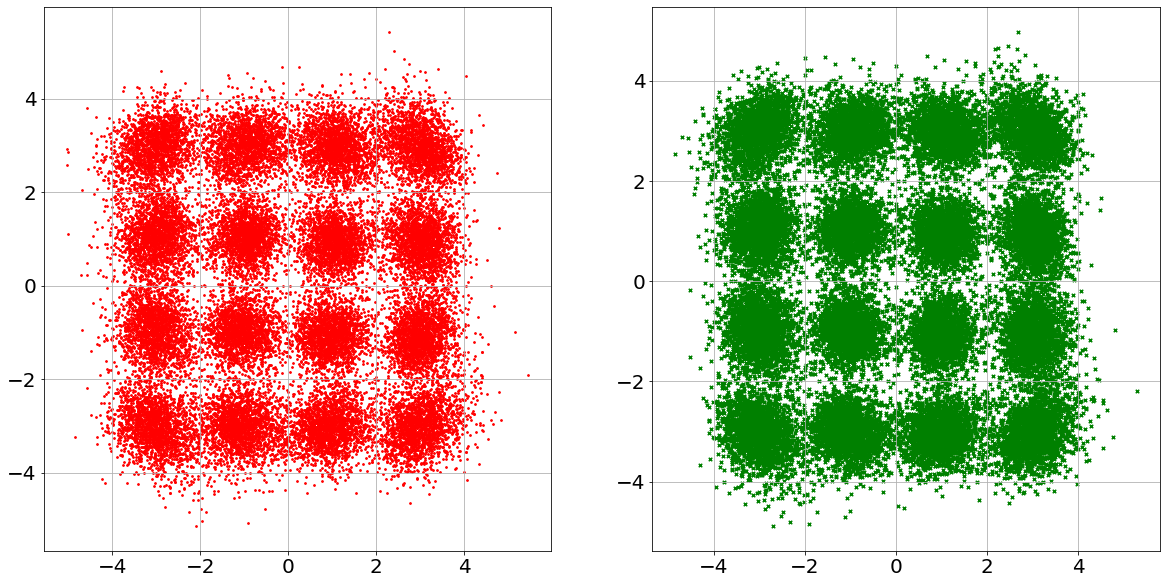

In [8]:
# fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# # for k_ind in [0, 1, 2]:
# for k_ind in [0]:
#     # axs[0][0].scatter(points_x[k_ind].real, points_x[k_ind].imag, s=12, c='r', marker='x')
#     axs[k_ind][0].scatter(points_x_shifted[k_ind].real, points_x_shifted[k_ind].imag, s=12, c='b', marker='x')
#     # axs[k_ind][0].scatter(points_orig_x[k_ind].real, points_orig_x[k_ind].imag, s=6, c='r', marker='.')
#     axs[k_ind][0].grid(True)
#
#     # axs[0][1].scatter(points_y[k_ind].real, points_y[k_ind].imag, s=12, c='r', marker='x')
#     axs[k_ind][1].scatter(points_y_shifted[k_ind].real, points_y_shifted[k_ind].imag, s=12, c='b', marker='x')
#     # axs[k_ind][1].scatter(points_orig_y[k_ind].real, points_orig_y[k_ind].imag, s=6, c='r', marker='.')
#     axs[k_ind][1].grid(True)

plot_range = range(32768)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(points_x_shifted_orig[plot_range].real, points_x_shifted_orig[plot_range].imag, s=12, c='red', marker='.')
# axs[0].scatter(points_x_shifted[plot_range].real, points_x_shifted[plot_range].imag, s=12, c='green', marker='x')
axs[0].scatter(points_orig_x.real, points_orig_x.imag, s=6, c='r', marker='.')
axs[0].grid(True)

# axs[0][1].scatter(points_y[k_ind].real, points_y[k_ind].imag, s=12, c='r', marker='x')
# axs[1].scatter(points_y_shifted_orig.real, points_y_shifted_orig.imag, s=12, c='red', marker='x')
# axs[1].scatter(points_y_shifted.real, points_y_shifted.imag, s=12, c='green', marker='x')
# axs[1].scatter(points_orig_y.real, points_orig_y.imag, s=6, c='r', marker='.')
# axs[1].grid(True)

axs[1].scatter(points_x_shifted[plot_range].real, points_x_shifted[plot_range].imag, s=12, c='green', marker='x')
# axs[1].scatter(points_orig_y.real, points_orig_y.imag, s=6, c='r', marker='.')
axs[1].grid(True)

/tmp/ipykernel_8596/3121311008.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axs[0][0].hist2d(points_x_shifted_orig[plot_range].real,
/tmp/ipykernel_8596/3121311008.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axs[0][1].hist2d(points_x_shifted[plot_range].real,


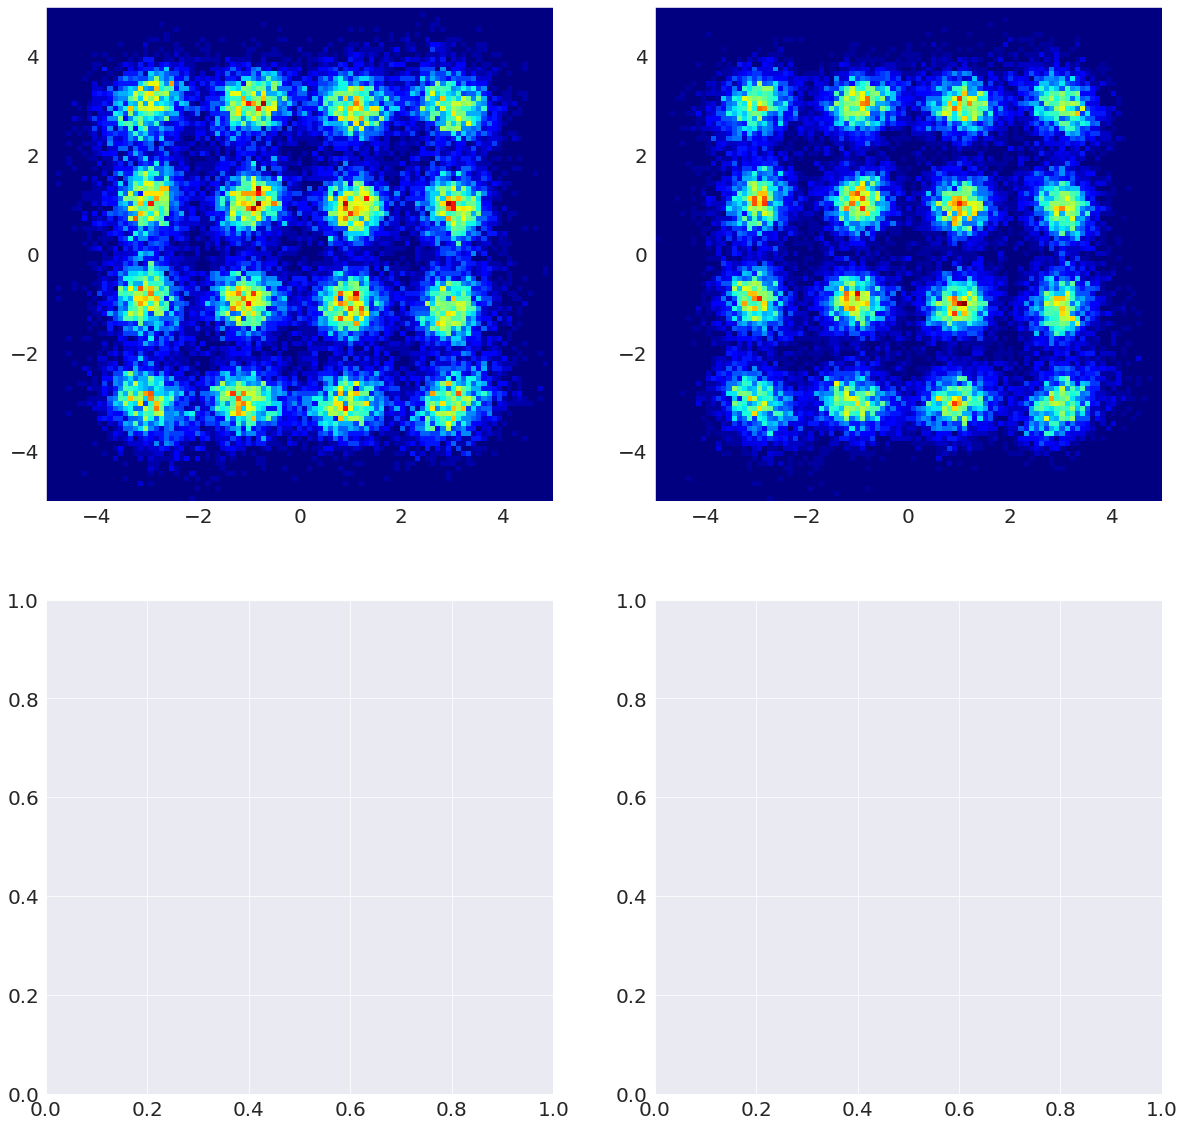

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

plot_max_value = 5
x_min, x_max = -plot_max_value, plot_max_value
y_min, y_max = x_min, x_max
n_bins = 100
x_bins = np.linspace(x_min, x_max, n_bins)
y_bins = np.linspace(y_min, y_max, n_bins)
color_map = plt.cm.jet

axs[0][0].hist2d(points_x_shifted_orig[plot_range].real,
                 points_x_shifted_orig[plot_range].imag,
                 bins=[x_bins, y_bins], cmap=color_map)
axs[0][0].grid(True)

axs[0][1].hist2d(points_x_shifted[plot_range].real,
                 points_x_shifted[plot_range].imag,
                 bins=[x_bins, y_bins], cmap=color_map)
axs[0][1].grid(True)


# axs[1][0].hist2d(points_predict_train.real * scale_constellation,
#                  points_predict_train.imag * scale_constellation,
#                  bins=[x_bins, y_bins], cmap=color_map)
axs[1][0].grid(True)

# axs[1][1].hist2d(points_orig_train.real * scale_constellation,
#                  points_orig_train.imag * scale_constellation,
#                  bins=[x_bins, y_bins], cmap=color_map)
axs[1][1].grid(True)


In [ ]:
dt = 1 / wdm['sample_freq']
t_grid = (np.arange(ft_filter_size) - ft_filter_size / 2) * dt

f_coef = 1.0
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
axs[0].plot(freq, np.absolute(ft_init_filter), linewidth=5, color='blue')
axs[0].plot(freq, np.absolute(spectrum), linewidth=3, color='green')
axs[0].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[0].grid(True)

# axs[1].plot(freq, np.absolute(spectrum), linewidth=3, color='purple')
axs[1].plot(freq[:-1], (np.angle(spectrum[:-1]) - np.angle(spectrum[1:])), linewidth=3, color='yellow')
axs[1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[1].grid(True)

axs[2].plot(t_grid, ifft(ifftshift(spectrum)), linewidth=4, color='blue')
axs[2].plot(t_grid, ifft(ifftshift(ft_init_filter)), linewidth=2, color='yellow')
# axs[2].plot(freq, np.imag(ft_init_filter), linewidth=3, color='purple')
# axs[2].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[2].grid(True)